### MODEL EVALUATION - AUPRC 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import os
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.metrics import auc
import math

In [144]:
disease = 'kidney'
wandb_run_name = 'amber-flower-165'
k_consecutive_ones = 6

icd_only = True

predictions_path = '/datasets/amelatur/data_slices/' + disease + '/' + wandb_run_name + '/' + 'raw_predictions/'

onset_file_path = '/datasets/amelatur/data_slices/' + disease + '/onset_index.csv'
onset_indices_csv = pd.read_csv(onset_file_path, header=None, index_col=False).rename({0: 'Patient_ID', 1: 'Onset_Index'}, axis=1)

output_shape = (48,) # can be (8,) or (1,)
nb_timesteps_per_window = 8
new_nb_timesteps = 48
stride = 1


In [145]:
def mark_sequences(binary_array, k):
    count = 0
    start_index = None
    for i in range(len(binary_array)):
        if binary_array[i] == 1:
            if count == 0:
                start_index = i
            count += 1
            if count > k:
                binary_array[start_index+1:i+1] = 0
        else:
            if count <= k and start_index is not None:
                binary_array[start_index:i] = 0
            count = 0
            start_index = None
    # Handle the last sequence of 1s
    if count <= k and start_index is not None:
        binary_array[start_index:i+1] = 0
    return binary_array


In [146]:
def parallelize_prc_calc(idx, threshold, files, icd_only):

    total_events = 0
    captured_events = 0
    precision_total = []
    total_pts = 0
    ground_truths = []
    predictions = []

    # read positive ICD patients
    pos_ICD_pts = []
    path = '/datasets/amelatur/data_slices/ICD_pt_ids/' + disease + '/pos_pts.txt'
    with open (path, 'r') as f:
        for line in f:
            pos_ICD_pts.append(line.strip())

    # read negative ICD patients
    neg_ICD_pts = []
    path = '/datasets/amelatur/data_slices/ICD_pt_ids/' + disease + '/neg_pts.txt'
    with open (path, 'r') as f:
        for line in f:
            neg_ICD_pts.append(line.strip())


    
    for file in (files):
        filename_parts = file.split('_')
        pt_id = int(filename_parts[0])
        onset_index = onset_indices_csv[onset_indices_csv['Patient_ID'] == pt_id]['Onset_Index'].values[0]

        predictions_probability = np.load(predictions_path + file)
        original_data_size = (predictions_probability.shape[0] - 1) * stride + nb_timesteps_per_window

        if output_shape[0] == 48: # one binary output per input timestep

            new_stride = stride * 6
            original_data_size = (predictions_probability.shape[0] - 1) * new_stride + new_nb_timesteps
            final_preds = np.zeros((original_data_size,))
            start_index = 0
            for i, window_data in enumerate(predictions_probability):
                window_data = window_data.reshape((window_data.shape[0],))
                if i == 0:
                    final_preds[start_index:new_nb_timesteps] = window_data
                    start_index = start_index + new_nb_timesteps
                else:
                    end_index = start_index + new_stride
                    final_preds[start_index:end_index] = window_data[new_nb_timesteps - new_stride :] 
                    start_index = end_index
            final_preds = (final_preds > threshold).astype(int)

        final_preds = mark_sequences(final_preds, k_consecutive_ones)

        targets = (np.zeros((final_preds.shape))).astype(int)
        if np.isnan(onset_index) == False: # if pt is labeled positive through medical criteria

            if icd_only and str(pt_id) not in pos_ICD_pts: # if positive patient not in ICD list, skip them
                continue

            if int(onset_index) < 2*4:
                continue # skip patients with onset index less than 4 hours
            
            onset_index = int(onset_index) * 6
            #start_event = max(0, onset_index - 8 * 12)
            start_event = 0
            targets[start_event:onset_index]  = 1

            targets = targets[:onset_index]
            final_preds = final_preds[:onset_index]
            ground_truth = 1
        else: # if pt is labeled negative through medical criteria
            if icd_only and str(pt_id) not in neg_ICD_pts: # if negative patient not in ICD list, skip them
                continue
            ground_truth = 0

        if np.sum(final_preds) > 0:
            predicted = 1
        else:
            predicted = 0
        
        ground_truths.append(ground_truth)
        predictions.append(predicted)

    tn, fp, fn, tp = confusion_matrix(ground_truths, predictions).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)

    
        
        
        # total_alarms = np.sum(final_preds)
        # bitwise_and = targets & final_preds
        # true_alarms = np.sum(bitwise_and)
            
        # precision = true_alarms/total_alarms
        # precision_total.append(precision)

        # positive_event = np.sum(targets) > 0
        # if positive_event:
        #     total_events += 1
        #     if true_alarms > 0:
        #         captured_events += 1
        
    #     total_pts += 1

    # final_precision = np.nanmean(precision_total)
    # final_recall = captured_events/total_events

    #return final_precision, final_recall, idx
    return tn, fp, fn, tp, precision, recall, specificity, idx



    # print("Precision: "+ str(final_precision) + " Recall: " + str(final_recall))
    # print("Total patients: " + str(total_pts) + ", total positive patients: " + str(total_events))

In [147]:
precisions = np.zeros(100)
recalls = np.zeros(100)
specificities = np.zeros(100)
fpr = np.zeros(100)
thresholds = np.arange(0, 1, 0.01).tolist()
files = os.listdir(predictions_path)
    


temp = Parallel(n_jobs=-1)(delayed(parallelize_prc_calc)(idx, threshold, files, icd_only) for (idx, threshold) in tqdm(enumerate(thresholds)))
    
for item in temp:

    tn, fp, fn, tp, precision, recall, specificity, idx = item

    specificities[idx] = specificity
    precisions[idx] = precision
    recalls[idx] = recall
    fpr[idx] = 1 - specificity


100it [03:08,  1.89s/it]


AUPRC: 0.30378224679868615


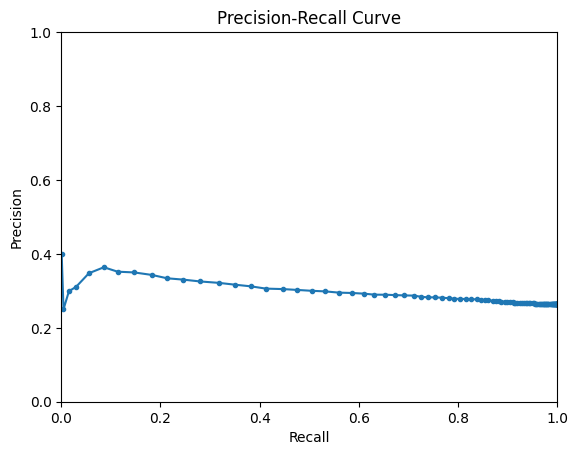

In [155]:
precisions_rev = precisions[::-1]
recalls_rev = recalls[::-1]

# precisions_rev = precisions_rev[1:]
# recalls_rev = recalls_rev[1:]

auprc = auc(recalls_rev, precisions_rev)
print("AUPRC: " + str(auprc))

plt.plot(recalls_rev, precisions_rev, marker='.')
plt.xlabel('Recall')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [156]:
precisions


array([0.26417124, 0.26417124, 0.26417124, 0.26412049, 0.26412049,
       0.26418344, 0.2641611 , 0.26408185, 0.26408792, 0.26411638,
       0.26406553, 0.2639862 , 0.26394132, 0.26384541, 0.26369234,
       0.26383485, 0.26382426, 0.2638934 , 0.26388286, 0.26378637,
       0.26402174, 0.26387378, 0.26351351, 0.26354895, 0.26356674,
       0.26375192, 0.26350461, 0.26369035, 0.26383682, 0.26413428,
       0.26439327, 0.26485286, 0.26507901, 0.26503738, 0.26518966,
       0.26540231, 0.26536816, 0.26547673, 0.26560907, 0.26578828,
       0.26621822, 0.2657967 , 0.26631434, 0.26630498, 0.26686761,
       0.26679083, 0.26723633, 0.26754593, 0.26736892, 0.26792947,
       0.26842987, 0.26920299, 0.26977196, 0.26972477, 0.27055343,
       0.2711548 , 0.27197388, 0.27281947, 0.27351849, 0.27407023,
       0.27517395, 0.27653631, 0.27699973, 0.2773224 , 0.27804743,
       0.27808316, 0.27877311, 0.28012268, 0.28144607, 0.28233679,
       0.28246652, 0.28384836, 0.28709942, 0.28762485, 0.28845

AUROC: 0.5569127594352313


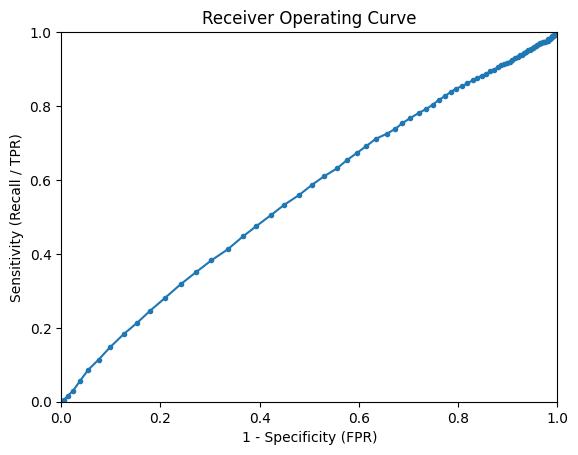

In [150]:
fpr_rev = fpr[::-1]
recalls_rev = recalls[::-1]
# fpr_rev = fpr_rev[4:]
# recalls_rev = recalls_rev[4:]

auroc = auc(fpr_rev, recalls_rev)
print("AUROC: " + str(auroc))

plt.plot(fpr_rev, recalls_rev, marker='.')
plt.ylabel('Sensitivity (Recall / TPR)')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel('1 - Specificity (FPR)')
plt.title('Receiver Operating Curve')
plt.show()

### FIXED THRESHOLD - Confusion Matrices

In [151]:
threshold = 0.5

disease = 'kidney'
wandb_run_name = 'amber-flower-165'
k_consecutive_ones = 6

icd_only = True

predictions_path = '/datasets/amelatur/data_slices/' + disease + '/' + wandb_run_name + '/' + 'raw_predictions/'

onset_file_path = '/datasets/amelatur/data_slices/' + disease + '/onset_index.csv'
onset_indices_csv = pd.read_csv(onset_file_path, header=None, index_col=False).rename({0: 'Patient_ID', 1: 'Onset_Index'}, axis=1)

output_shape = (48,) # can be (8,) or (1,)
nb_timesteps_per_window = 8
new_nb_timesteps = 48
stride = 1


In [152]:
files = os.listdir(predictions_path)

idx = 0 # dummy value just to make the function work

tn, fp, fn, tp, precision, recall, specificity, idx = parallelize_prc_calc(idx, threshold, files, icd_only)

In [153]:
tn, fp, fn, tp

(728, 6113, 213, 2243)

In [154]:
precision, recall, specificity

(0.2684298707515558, 0.9132736156351792, 0.10641719046922965)